# TP - Mountain Car - SARSA 

TP réalisé par Marine Troadec 2021-2022

### Imports ... 

In [105]:
import gym
import numpy as np
import matplotlib.pyplot as plt 
from collections import defaultdict
import random
import statistics
from statistics import mean 

env = gym.make("MountainCar-v0")

In [106]:
# Changement des paramètres d'affichage par défaut
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 20, 10
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['font.size'] = 24
mpl.rcParams['lines.markersize'] = 15
mpl.rcParams['axes.grid'] = True
# mpl.rcParams.find_all('')

## Visualisation de l'environnement 

In [107]:
env.reset()
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample()) # action aléatoire
env.close()

In [108]:
env.viewer = False

## Regardons les paramètres 

In [109]:
print('Position :', env.observation_space.high)
print('Velocity :', env.observation_space.low)
print("Nombre d'actions possibles :", env.action_space.n)

Position : [0.6  0.07]
Velocity : [-1.2  -0.07]
Nombre d'actions possibles : 3


## Fixons les hypermaratrès

In [110]:
ALPHA = 0.1    # learning rate
GAMMA = 0.9    # importance de la prochaine action
EPSILON = 0.05  # exploration 

In [111]:
EPISODE_DISPLAY = 200  # enregistrement des données tous les 200 épisodes
EPISODES = 30000  # nombre d'épisodes 
DISCRETE_SIZE = 40

## Discretisation de l'espace 

In [112]:
def discretised_state(env, discrete_size):
    return np.linspace(env.observation_space.low, env.observation_space.high, discrete_size)

DISCRATE_STATE = discretised_state(env, DISCRETE_SIZE)

print('Espace discretisé :', DISCRATE_STATE)

Espace discretisé : [[-1.2        -0.07      ]
 [-1.1538461  -0.06641026]
 [-1.1076924  -0.06282052]
 [-1.0615385  -0.05923077]
 [-1.0153847  -0.05564103]
 [-0.96923083 -0.05205128]
 [-0.923077   -0.04846154]
 [-0.8769231  -0.0448718 ]
 [-0.8307693  -0.04128205]
 [-0.7846154  -0.03769231]
 [-0.7384616  -0.03410257]
 [-0.6923077  -0.03051282]
 [-0.64615387 -0.02692308]
 [-0.6        -0.02333333]
 [-0.5538462  -0.01974359]
 [-0.50769234 -0.01615385]
 [-0.4615385  -0.0125641 ]
 [-0.41538465 -0.00897436]
 [-0.3692308  -0.00538462]
 [-0.32307696 -0.00179487]
 [-0.27692312  0.00179487]
 [-0.23076928  0.00538462]
 [-0.18461537  0.00897436]
 [-0.13846159  0.0125641 ]
 [-0.09230769  0.01615384]
 [-0.0461539   0.01974358]
 [ 0.          0.02333333]
 [ 0.04615378  0.02692308]
 [ 0.09230769  0.03051282]
 [ 0.13846147  0.03410256]
 [ 0.18461537  0.03769231]
 [ 0.23076916  0.04128205]
 [ 0.27692306  0.04487179]
 [ 0.32307696  0.04846153]
 [ 0.36923075  0.05205128]
 [ 0.41538465  0.05564102]
 [ 0.461

La matrice ci dessus représente en colonne : la position, la velocité. Les lignes vont du minimum au maximum. 

## Dicretisation d'un couple (position, volocité)

La fonction ci dessous prend en entrée les états et renvoie sont indice en ligne dans la matrice des valeurs dicrétisées ci-dessus. L'indice choisie correspond à la valeur minimale la plus proche. 

In [113]:
def discretize_state(state, discrete_states=DISCRATE_STATE):
    return ( 
        np.where((discrete_states[:-1,0] <= state[0]) * (state[0] < discrete_states[1:,0]))[0][0], 
        np.where((discrete_states[:-1,1] <= state[1]) * (state[1] < discrete_states[1:,1]))[0][0]
    )

## Dictionnaire des récompenses en fonctions des états et de l'action choisie

Les états (state) sont définis comme (ind_position, ind_volicité) où ind représente l'indice de la valeur dans la matrice DISCRATE_STATE. 
L'action peut prendre 3 valeurs : 0,1,2. 

In [114]:
def get_utility(q, state, action):
    return q.get((state, action), 0.0)  

# Mise en place de SARSA

In [120]:
def sarsa(EPSILON=EPSILON, GAMMA=GAMMA, ALPHA=ALPHA, EPISODE=EPISODES,
         EPISODE_DISPLAY=EPISODE_DISPLAY, DISCRATE_STATE=DISCRATE_STATE, env=env) :
    
    ep_rewards = []
    ep_rewards_table = {'ep': [], 'avg': [], 'min': [], 'max': [], 'iter': []}
    Q = defaultdict(lambda: np.zeros(len(DISCRATE_STATE)))
    
    for episode in range(EPISODES) : 

        episode_reward = 0
        done = False 
        current_state = discretize_state(env.reset(), DISCRATE_STATE) 

        if random.random() < EPSILON :  
            action = env.action_space.sample()
        else:
            q = [get_utility(Q,current_state, act) for act in range(env.action_space.n)]
            max_utility = max(q)
            if q.count(max_utility) > 1:
                best_actions = [i for i in range(env.action_space.n) if q[i] == max_utility]
                action = random.choice(best_actions)
            else:
                action = q.index(max_utility) 

        i=0

        for iter in range(200) : # On bloque le nombre d'essaie par épisode à 200
            if not done :

                new_state, reward, done, _ = env.step(action)
                new_state = discretize_state(new_state, DISCRATE_STATE)

                if random.random() < EPSILON :  
                    new_action = env.action_space.sample()

                else:

                    q = [get_utility(Q, new_state, act) for act in range(env.action_space.n)]
                    max_utility = max(q)

                    if q.count(max_utility) > 1:
                        best_actions = [i for i in range(env.action_space.n) if q[i] == max_utility]
                        new_action = random.choice(best_actions)

                    else:
                        new_action = q.index(max_utility) 

                if not done: 

                    old_utility = Q.get((current_state, action), None)

                    if old_utility is None:
                        Q[(current_state, action)] = reward
                    else:
                        next_max_utility = get_utility(Q, new_state, new_action) 
                        Q[(current_state, action)] = old_utility + ALPHA * (reward + GAMMA * next_max_utility - old_utility)

                elif new_state[0] >= env.goal_position:
                    Q[(current_state,action)] = 0

                current_state = new_state
                action = new_action

                episode_reward += reward

            else : 
                if i == 0 : 
                    i = iter 

        ep_rewards.append(episode_reward)


        if not episode % EPISODE_DISPLAY:

            avg_reward = sum(ep_rewards[-EPISODE_DISPLAY:])/len(ep_rewards[-EPISODE_DISPLAY:])
            ep_rewards_table['ep'].append(episode)
            ep_rewards_table['avg'].append(avg_reward)
            ep_rewards_table['min'].append(min(ep_rewards[-EPISODE_DISPLAY:]))
            ep_rewards_table['max'].append(max(ep_rewards[-EPISODE_DISPLAY:]))
            ep_rewards_table['iter'].append(0) if i ==0  else ep_rewards_table['iter'].append(i)


            print(f"Episode:{episode} avg:{avg_reward} min:{min(ep_rewards[-EPISODE_DISPLAY:])} max:{max(ep_rewards[-EPISODE_DISPLAY:])}")
    
    env.close()
    
    return ep_rewards_table

# Premiers résulats 

In [121]:
ep_rewards_table = sarsa() 

Episode:0 avg:-200.0 min:-200.0 max:-200.0
Episode:200 avg:-200.0 min:-200.0 max:-200.0
Episode:400 avg:-200.0 min:-200.0 max:-200.0
Episode:600 avg:-200.0 min:-200.0 max:-200.0
Episode:800 avg:-200.0 min:-200.0 max:-200.0
Episode:1000 avg:-200.0 min:-200.0 max:-200.0
Episode:1200 avg:-200.0 min:-200.0 max:-200.0
Episode:1400 avg:-199.72 min:-200.0 max:-171.0
Episode:1600 avg:-200.0 min:-200.0 max:-200.0
Episode:1800 avg:-199.815 min:-200.0 max:-163.0
Episode:2000 avg:-199.445 min:-200.0 max:-167.0
Episode:2200 avg:-199.35 min:-200.0 max:-168.0
Episode:2400 avg:-199.005 min:-200.0 max:-159.0
Episode:2600 avg:-198.67 min:-200.0 max:-159.0
Episode:2800 avg:-197.485 min:-200.0 max:-152.0
Episode:3000 avg:-198.485 min:-200.0 max:-156.0
Episode:3200 avg:-195.865 min:-200.0 max:-158.0
Episode:3400 avg:-194.735 min:-200.0 max:-154.0
Episode:3600 avg:-194.995 min:-200.0 max:-157.0
Episode:3800 avg:-191.165 min:-200.0 max:-153.0
Episode:4000 avg:-196.685 min:-200.0 max:-155.0
Episode:4200 avg:-

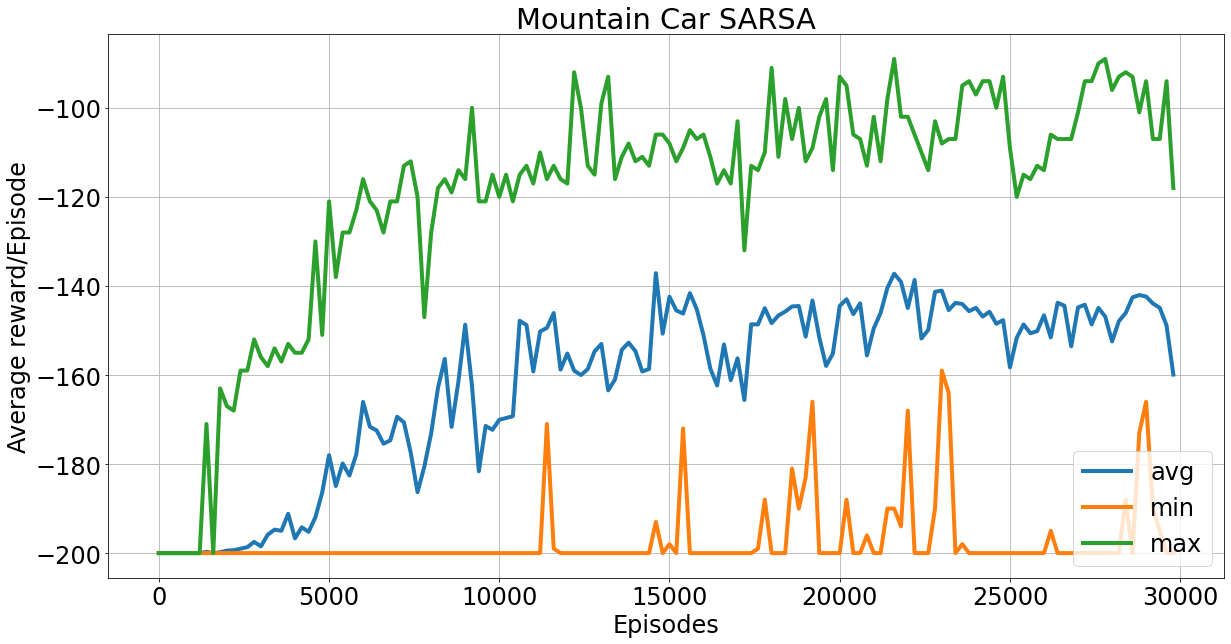

In [122]:
plt.plot(ep_rewards_table['ep'], ep_rewards_table['avg'], label="avg")
plt.plot(ep_rewards_table['ep'], ep_rewards_table['min'], label="min")
plt.plot(ep_rewards_table['ep'], ep_rewards_table['max'], label="max")
plt.legend(loc=4) #bottom right
plt.title('Mountain Car SARSA')
plt.ylabel('Average reward/Episode')
plt.xlabel('Episodes')
plt.show()

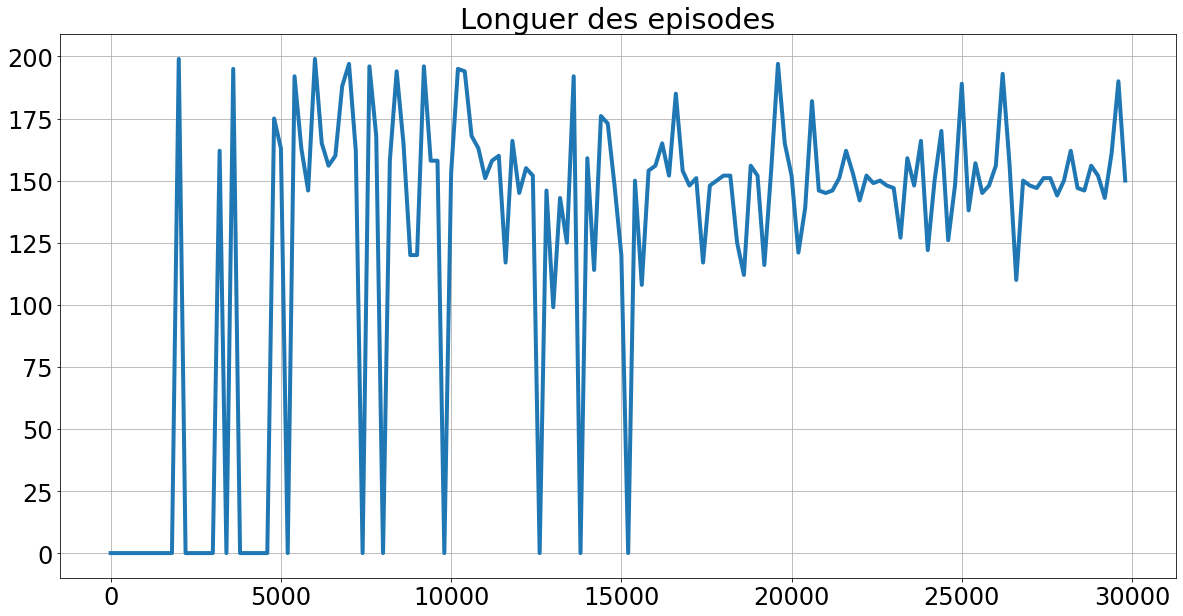

In [123]:
plt.plot(ep_rewards_table['ep'], ep_rewards_table['iter'], label='all')
plt.title('Longuer des episodes')
plt.show()


# Etudions les hyperparamètres 

In [124]:
EPISODES=20000

## Variation d'epsilon

In [125]:
EPSILONS = [0.05, 0.10, 0.15, 0.20]
res_epsi = {'0.05': {}, '0.10': {}, '0.15': {}, '0.20': {}}

In [126]:
for (cle, valeur), eps in zip(res_epsi.items(), EPSILONS) : 
    print('--------------- Epislon {} ---------------'.format(cle))
    res_epsi[cle] = sarsa(EPSILON=eps) 

--------------- Epislon 0.05 ---------------
Episode:0 avg:-200.0 min:-200.0 max:-200.0
Episode:200 avg:-200.0 min:-200.0 max:-200.0
Episode:400 avg:-200.0 min:-200.0 max:-200.0
Episode:600 avg:-200.0 min:-200.0 max:-200.0
Episode:800 avg:-200.0 min:-200.0 max:-200.0
Episode:1000 avg:-200.0 min:-200.0 max:-200.0
Episode:1200 avg:-200.0 min:-200.0 max:-200.0
Episode:1400 avg:-200.0 min:-200.0 max:-200.0
Episode:1600 avg:-200.0 min:-200.0 max:-200.0
Episode:1800 avg:-199.89 min:-200.0 max:-180.0
Episode:2000 avg:-199.655 min:-200.0 max:-172.0
Episode:2200 avg:-199.64 min:-200.0 max:-166.0
Episode:2400 avg:-198.805 min:-200.0 max:-162.0
Episode:2600 avg:-197.68 min:-200.0 max:-157.0
Episode:2800 avg:-197.925 min:-200.0 max:-156.0
Episode:3000 avg:-193.98 min:-200.0 max:-153.0
Episode:3200 avg:-193.765 min:-200.0 max:-158.0
Episode:3400 avg:-197.76 min:-200.0 max:-154.0
Episode:3600 avg:-189.87 min:-200.0 max:-151.0
Episode:3800 avg:-190.495 min:-200.0 max:-152.0
Episode:4000 avg:-196.625 

Episode:14200 avg:-155.495 min:-200.0 max:-86.0
Episode:14400 avg:-150.875 min:-200.0 max:-118.0
Episode:14600 avg:-162.605 min:-200.0 max:-99.0
Episode:14800 avg:-176.61 min:-200.0 max:-151.0
Episode:15000 avg:-163.525 min:-200.0 max:-120.0
Episode:15200 avg:-149.88 min:-200.0 max:-113.0
Episode:15400 avg:-150.475 min:-200.0 max:-109.0
Episode:15600 avg:-148.37 min:-200.0 max:-109.0
Episode:15800 avg:-155.89 min:-200.0 max:-110.0
Episode:16000 avg:-164.44 min:-200.0 max:-120.0
Episode:16200 avg:-155.61 min:-200.0 max:-115.0
Episode:16400 avg:-145.455 min:-200.0 max:-112.0
Episode:16600 avg:-147.175 min:-200.0 max:-108.0
Episode:16800 avg:-147.595 min:-200.0 max:-115.0
Episode:17000 avg:-157.575 min:-200.0 max:-111.0
Episode:17200 avg:-156.665 min:-200.0 max:-113.0
Episode:17400 avg:-147.78 min:-200.0 max:-96.0
Episode:17600 avg:-146.845 min:-200.0 max:-106.0
Episode:17800 avg:-157.67 min:-200.0 max:-114.0
Episode:18000 avg:-170.2 min:-200.0 max:-120.0
Episode:18200 avg:-167.775 min:-2

Episode:8200 avg:-171.99 min:-200.0 max:-118.0
Episode:8400 avg:-176.525 min:-200.0 max:-115.0
Episode:8600 avg:-180.935 min:-200.0 max:-119.0
Episode:8800 avg:-178.315 min:-200.0 max:-116.0
Episode:9000 avg:-176.685 min:-200.0 max:-122.0
Episode:9200 avg:-179.89 min:-200.0 max:-126.0
Episode:9400 avg:-182.905 min:-200.0 max:-127.0
Episode:9600 avg:-179.265 min:-200.0 max:-123.0
Episode:9800 avg:-175.565 min:-200.0 max:-119.0
Episode:10000 avg:-172.345 min:-200.0 max:-117.0
Episode:10200 avg:-171.45 min:-200.0 max:-119.0
Episode:10400 avg:-174.385 min:-200.0 max:-117.0
Episode:10600 avg:-176.77 min:-200.0 max:-121.0
Episode:10800 avg:-175.69 min:-200.0 max:-118.0
Episode:11000 avg:-172.635 min:-200.0 max:-115.0
Episode:11200 avg:-169.325 min:-200.0 max:-116.0
Episode:11400 avg:-177.915 min:-200.0 max:-118.0
Episode:11600 avg:-165.915 min:-200.0 max:-120.0
Episode:11800 avg:-163.33 min:-200.0 max:-116.0
Episode:12000 avg:-174.665 min:-200.0 max:-124.0
Episode:12200 avg:-168.615 min:-200

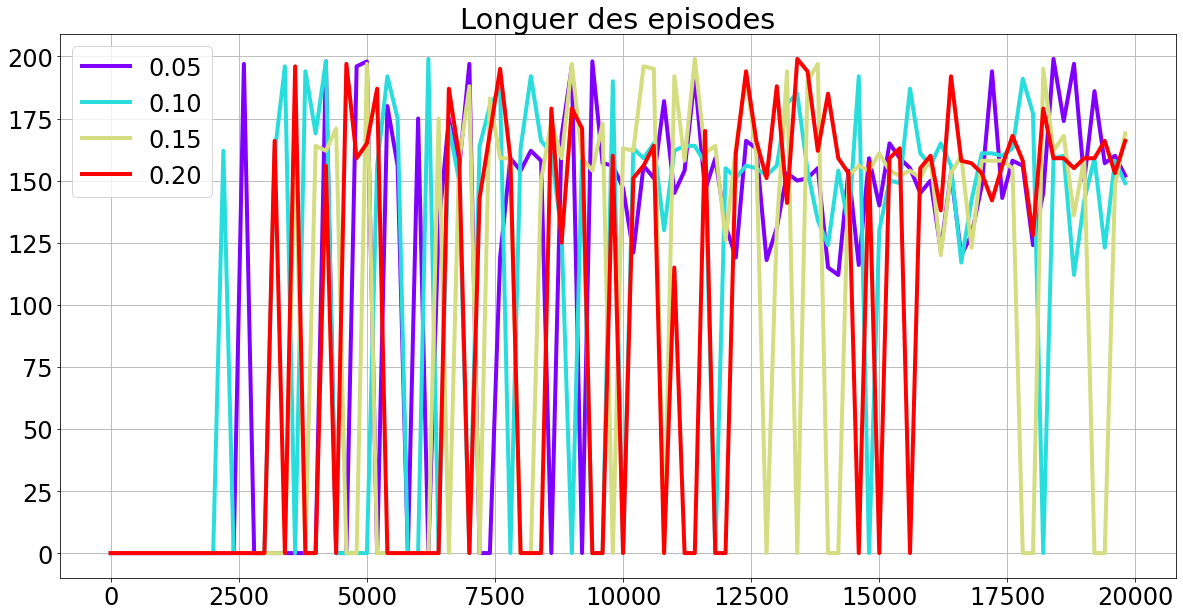

In [127]:
import matplotlib.cm as cm 
colors = cm.rainbow(np.linspace(0, 1, len(EPSILONS)))
for (cle, valeur), col in zip(res_epsi.items(), colors):
    plt.plot(valeur['ep'], valeur['iter'], label=cle, c=col)
    
plt.title('Longuer des episodes')
plt.legend()
plt.show()

In [128]:
print('Lorsque que le but est atteint avant 200 itérations : ')
for cle, valeur in res_epsi.items():
    print("En moyenne Epsilon {} permet d'atteindre le drapeau en {} ".format(cle, mean([i for i in valeur['iter'] if i != 0])))

Lorsque que le but est atteint avant 200 itérations : 
En moyenne Epsilon 0.05 permet d'atteindre le drapeau en 156.50704225352112 
En moyenne Epsilon 0.10 permet d'atteindre le drapeau en 161.02941176470588 
En moyenne Epsilon 0.15 permet d'atteindre le drapeau en 164.54237288135593 
En moyenne Epsilon 0.20 permet d'atteindre le drapeau en 163.74576271186442 


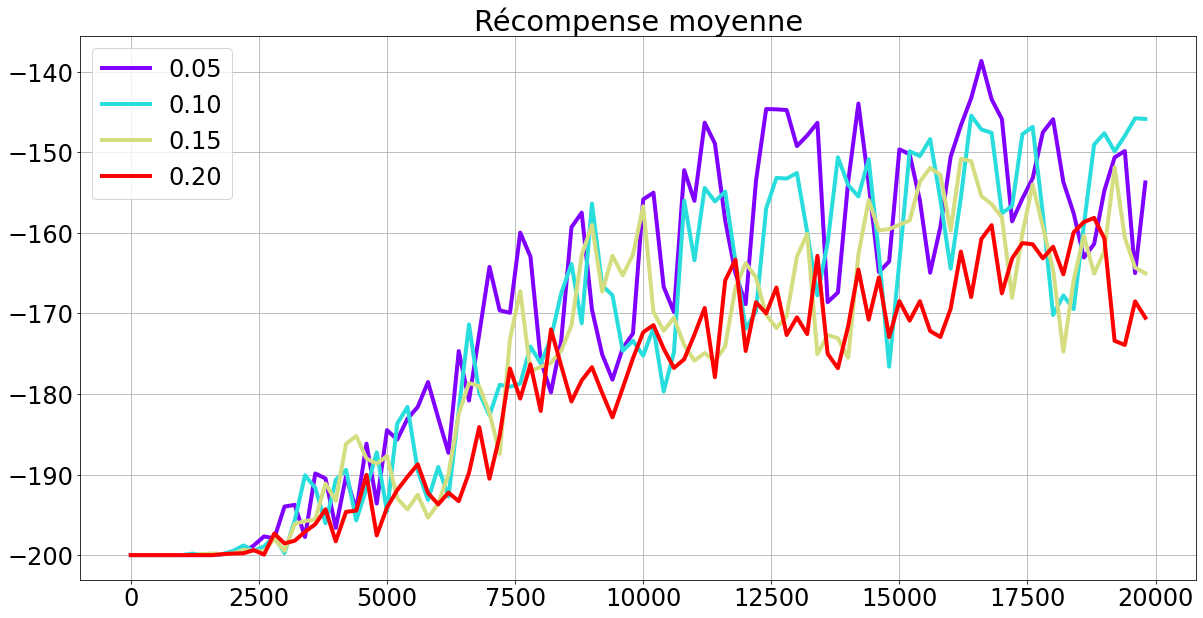

In [143]:
colors = cm.rainbow(np.linspace(0, 1, len(EPSILONS)))
for (cle, valeur), col in zip(res_epsi.items(), colors):
    plt.plot(valeur['ep'], valeur['avg'], label=cle, c=col)
    
plt.title('Récompense moyenne')
plt.legend()
plt.show()

## Variation de Gamma 

In [129]:
GAMMAS = [0.5, 0.75, 0.90, 0.95]
res_gam = {'0.5': {}, '0.75': {}, '0.90': {}, '0.95': {}}

In [130]:
for (cle, valeur), gam in zip(res_gam.items(), GAMMAS) : 
    print('--------------- GAMMA {} ---------------'.format(cle))
    res_gam[cle] = sarsa(GAMMA=gam) 

--------------- GAMMA 0.5 ---------------
Episode:0 avg:-200.0 min:-200.0 max:-200.0
Episode:200 avg:-200.0 min:-200.0 max:-200.0
Episode:400 avg:-200.0 min:-200.0 max:-200.0
Episode:600 avg:-200.0 min:-200.0 max:-200.0
Episode:800 avg:-200.0 min:-200.0 max:-200.0
Episode:1000 avg:-200.0 min:-200.0 max:-200.0
Episode:1200 avg:-200.0 min:-200.0 max:-200.0
Episode:1400 avg:-200.0 min:-200.0 max:-200.0
Episode:1600 avg:-200.0 min:-200.0 max:-200.0
Episode:1800 avg:-200.0 min:-200.0 max:-200.0
Episode:2000 avg:-200.0 min:-200.0 max:-200.0
Episode:2200 avg:-199.925 min:-200.0 max:-191.0
Episode:2400 avg:-199.735 min:-200.0 max:-171.0
Episode:2600 avg:-199.59 min:-200.0 max:-161.0
Episode:2800 avg:-199.78 min:-200.0 max:-166.0
Episode:3000 avg:-199.38 min:-200.0 max:-171.0
Episode:3200 avg:-200.0 min:-200.0 max:-200.0
Episode:3400 avg:-198.645 min:-200.0 max:-162.0
Episode:3600 avg:-199.075 min:-200.0 max:-163.0
Episode:3800 avg:-199.21 min:-200.0 max:-152.0
Episode:4000 avg:-199.755 min:-20

Episode:14200 avg:-198.61 min:-200.0 max:-153.0
Episode:14400 avg:-188.585 min:-200.0 max:-124.0
Episode:14600 avg:-177.875 min:-200.0 max:-113.0
Episode:14800 avg:-167.875 min:-200.0 max:-110.0
Episode:15000 avg:-170.035 min:-200.0 max:-113.0
Episode:15200 avg:-157.67 min:-200.0 max:-113.0
Episode:15400 avg:-170.46 min:-200.0 max:-119.0
Episode:15600 avg:-186.365 min:-200.0 max:-120.0
Episode:15800 avg:-166.74 min:-200.0 max:-113.0
Episode:16000 avg:-191.355 min:-200.0 max:-125.0
Episode:16200 avg:-184.235 min:-200.0 max:-118.0
Episode:16400 avg:-199.11 min:-200.0 max:-154.0
Episode:16600 avg:-199.83 min:-200.0 max:-166.0
Episode:16800 avg:-199.58 min:-200.0 max:-151.0
Episode:17000 avg:-199.815 min:-200.0 max:-163.0
Episode:17200 avg:-198.155 min:-200.0 max:-154.0
Episode:17400 avg:-196.42 min:-200.0 max:-120.0
Episode:17600 avg:-190.435 min:-200.0 max:-117.0
Episode:17800 avg:-198.875 min:-200.0 max:-158.0
Episode:18000 avg:-199.57 min:-200.0 max:-160.0
Episode:18200 avg:-197.925 mi

Episode:8400 avg:-179.445 min:-200.0 max:-137.0
Episode:8600 avg:-181.78 min:-200.0 max:-122.0
Episode:8800 avg:-172.905 min:-200.0 max:-117.0
Episode:9000 avg:-175.56 min:-200.0 max:-146.0
Episode:9200 avg:-165.17 min:-200.0 max:-124.0
Episode:9400 avg:-167.125 min:-200.0 max:-119.0
Episode:9600 avg:-155.635 min:-200.0 max:-111.0
Episode:9800 avg:-151.17 min:-200.0 max:-113.0
Episode:10000 avg:-153.475 min:-200.0 max:-116.0
Episode:10200 avg:-171.395 min:-200.0 max:-119.0
Episode:10400 avg:-176.285 min:-200.0 max:-146.0
Episode:10600 avg:-169.98 min:-200.0 max:-141.0
Episode:10800 avg:-156.89 min:-200.0 max:-103.0
Episode:11000 avg:-146.635 min:-200.0 max:-111.0
Episode:11200 avg:-148.455 min:-200.0 max:-92.0
Episode:11400 avg:-159.49 min:-200.0 max:-93.0
Episode:11600 avg:-152.815 min:-200.0 max:-116.0
Episode:11800 avg:-141.73 min:-195.0 max:-110.0
Episode:12000 avg:-142.475 min:-200.0 max:-111.0
Episode:12200 avg:-158.08 min:-200.0 max:-97.0
Episode:12400 avg:-152.3 min:-200.0 max:

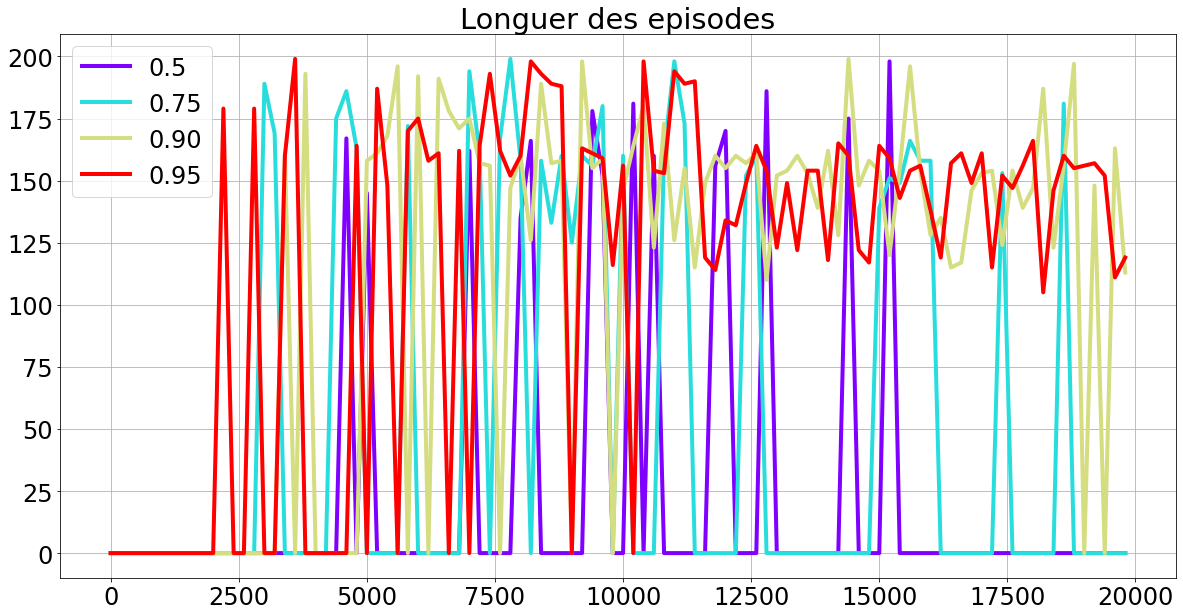

In [131]:
colors = cm.rainbow(np.linspace(0, 1, len(GAMMAS)))
for (cle, valeur), col in zip(res_gam.items(), colors):
    plt.plot(valeur['ep'], valeur['iter'], label=cle, c=col)
    
plt.title('Longuer des episodes')
plt.legend()
plt.show()

In [140]:
print('Lorsque que le but est atteint avant 200 itérations : ')
for cle, valeur in res_gam.items():
    print("En moyenne Gamma {} permet d'atteindre le drapeau en {}".format(cle, mean([i for i in valeur['iter'] if i != 0])))

Lorsque que le but est atteint avant 200 itérations : 
En moyenne Gamma 0.5 permet d'atteindre le drapeau en 166.5
En moyenne Gamma 0.75 permet d'atteindre le drapeau en 164.5
En moyenne Gamma 0.90 permet d'atteindre le drapeau en 155.3
En moyenne Gamma 0.95 permet d'atteindre le drapeau en 155.16216216216216


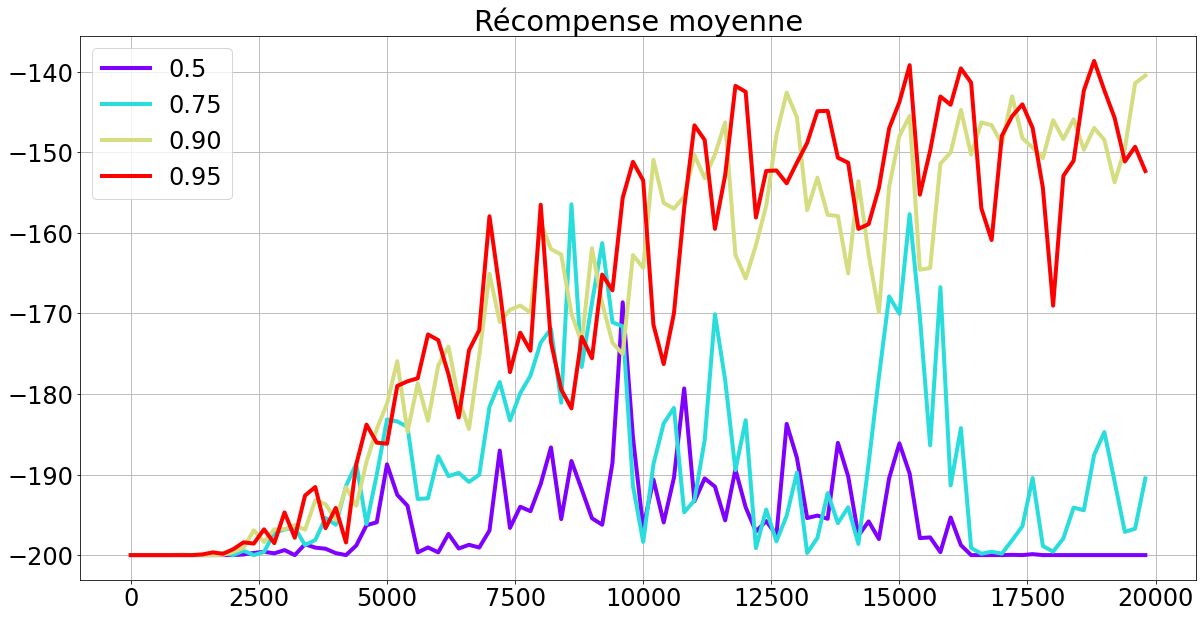

In [141]:
colors = cm.rainbow(np.linspace(0, 1, len(GAMMAS)))
for (cle, valeur), col in zip(res_gam.items(), colors):
    plt.plot(valeur['ep'], valeur['avg'], label=cle, c=col)
    
plt.title('Récompense moyenne')
plt.legend()
plt.show()

## Variation d'Alpha

In [133]:
ALPHAS = [0.05, 0.1, 0.2, 0.3]
res_alp = {'0.05': {}, '0.1': {}, '0.2': {}, '0.3': {}}

In [134]:
for (cle, valeur), alp in zip(res_alp.items(), ALPHAS) : 
    print('--------------- ALPHA {} ---------------'.format(cle))
    res_alp[cle] = sarsa(ALPHA=alp) 

--------------- ALPHA 0.05 ---------------
Episode:0 avg:-200.0 min:-200.0 max:-200.0
Episode:200 avg:-200.0 min:-200.0 max:-200.0
Episode:400 avg:-200.0 min:-200.0 max:-200.0
Episode:600 avg:-200.0 min:-200.0 max:-200.0
Episode:800 avg:-200.0 min:-200.0 max:-200.0
Episode:1000 avg:-200.0 min:-200.0 max:-200.0
Episode:1200 avg:-200.0 min:-200.0 max:-200.0
Episode:1400 avg:-200.0 min:-200.0 max:-200.0
Episode:1600 avg:-200.0 min:-200.0 max:-200.0
Episode:1800 avg:-200.0 min:-200.0 max:-200.0
Episode:2000 avg:-200.0 min:-200.0 max:-200.0
Episode:2200 avg:-199.89 min:-200.0 max:-178.0
Episode:2400 avg:-199.565 min:-200.0 max:-169.0
Episode:2600 avg:-200.0 min:-200.0 max:-200.0
Episode:2800 avg:-200.0 min:-200.0 max:-200.0
Episode:3000 avg:-199.675 min:-200.0 max:-164.0
Episode:3200 avg:-199.995 min:-200.0 max:-199.0
Episode:3400 avg:-200.0 min:-200.0 max:-200.0
Episode:3600 avg:-200.0 min:-200.0 max:-200.0
Episode:3800 avg:-199.345 min:-200.0 max:-171.0
Episode:4000 avg:-199.095 min:-200.

Episode:14200 avg:-155.92 min:-200.0 max:-113.0
Episode:14400 avg:-154.77 min:-200.0 max:-115.0
Episode:14600 avg:-148.465 min:-200.0 max:-113.0
Episode:14800 avg:-153.205 min:-200.0 max:-115.0
Episode:15000 avg:-159.105 min:-200.0 max:-114.0
Episode:15200 avg:-173.655 min:-200.0 max:-100.0
Episode:15400 avg:-169.41 min:-200.0 max:-137.0
Episode:15600 avg:-159.215 min:-200.0 max:-122.0
Episode:15800 avg:-152.29 min:-200.0 max:-114.0
Episode:16000 avg:-149.9 min:-172.0 max:-113.0
Episode:16200 avg:-147.0 min:-200.0 max:-111.0
Episode:16400 avg:-146.0 min:-200.0 max:-108.0
Episode:16600 avg:-154.345 min:-200.0 max:-96.0
Episode:16800 avg:-148.32 min:-200.0 max:-96.0
Episode:17000 avg:-141.06 min:-200.0 max:-101.0
Episode:17200 avg:-150.31 min:-198.0 max:-89.0
Episode:17400 avg:-146.805 min:-200.0 max:-111.0
Episode:17600 avg:-145.005 min:-198.0 max:-109.0
Episode:17800 avg:-149.17 min:-200.0 max:-110.0
Episode:18000 avg:-147.13 min:-191.0 max:-109.0
Episode:18200 avg:-147.17 min:-167.0 m

Episode:8400 avg:-168.35 min:-200.0 max:-145.0
Episode:8600 avg:-165.37 min:-200.0 max:-123.0
Episode:8800 avg:-165.415 min:-200.0 max:-123.0
Episode:9000 avg:-159.4 min:-200.0 max:-134.0
Episode:9200 avg:-161.815 min:-200.0 max:-115.0
Episode:9400 avg:-157.71 min:-200.0 max:-113.0
Episode:9600 avg:-165.045 min:-200.0 max:-114.0
Episode:9800 avg:-167.31 min:-200.0 max:-118.0
Episode:10000 avg:-169.795 min:-200.0 max:-125.0
Episode:10200 avg:-164.94 min:-200.0 max:-119.0
Episode:10400 avg:-165.41 min:-200.0 max:-118.0
Episode:10600 avg:-162.78 min:-200.0 max:-117.0
Episode:10800 avg:-165.04 min:-200.0 max:-112.0
Episode:11000 avg:-167.165 min:-200.0 max:-119.0
Episode:11200 avg:-160.585 min:-200.0 max:-110.0
Episode:11400 avg:-162.25 min:-200.0 max:-109.0
Episode:11600 avg:-162.675 min:-200.0 max:-137.0
Episode:11800 avg:-163.835 min:-200.0 max:-114.0
Episode:12000 avg:-153.805 min:-200.0 max:-112.0
Episode:12200 avg:-158.22 min:-197.0 max:-112.0
Episode:12400 avg:-159.245 min:-200.0 ma

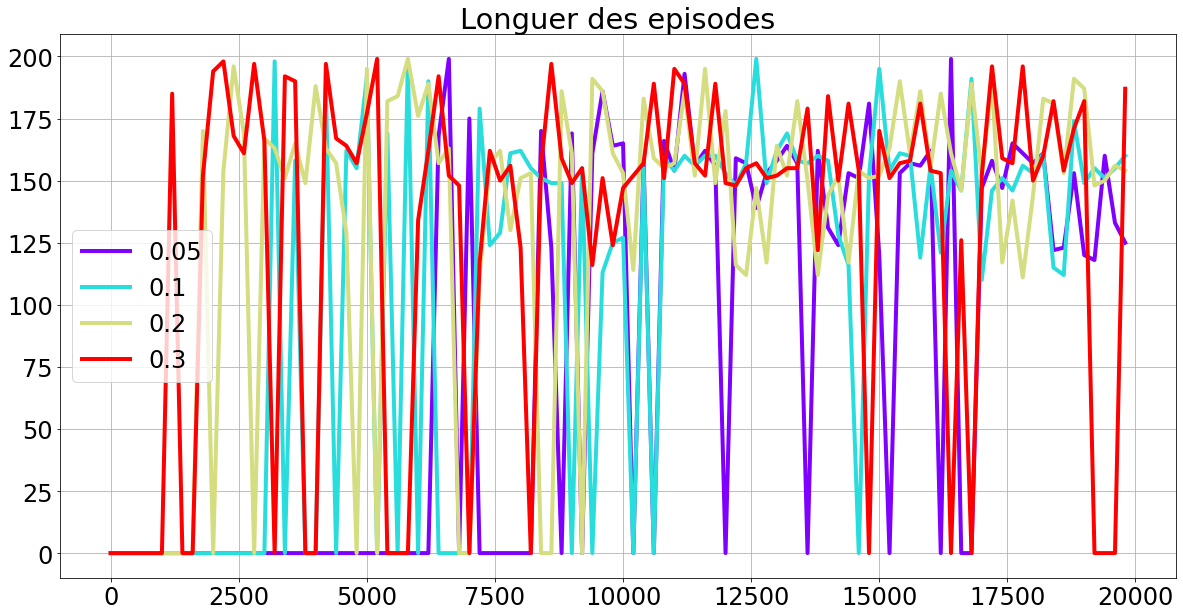

In [135]:
colors = cm.rainbow(np.linspace(0, 1, len(ALPHAS)))
for (cle, valeur), col in zip(res_alp.items(), colors):
    plt.plot(valeur['ep'], valeur['iter'], label=cle, c=col)
plt.title('Longuer des episodes')
plt.legend()
plt.show()

In [139]:
for cle, valeur in res_alp.items():
    print("En moyenne Alpha {} permet d'atteindre le drapeau en {}".format(cle, mean([i for i in valeur['iter'] if i != 0])))

En moyenne Alpha 0.05 permet d'atteindre le drapeau en 155.11764705882354
En moyenne Alpha 0.1 permet d'atteindre le drapeau en 154.5441176470588
En moyenne Alpha 0.2 permet d'atteindre le drapeau en 159.91463414634146
En moyenne Alpha 0.3 permet d'atteindre le drapeau en 163.24358974358975


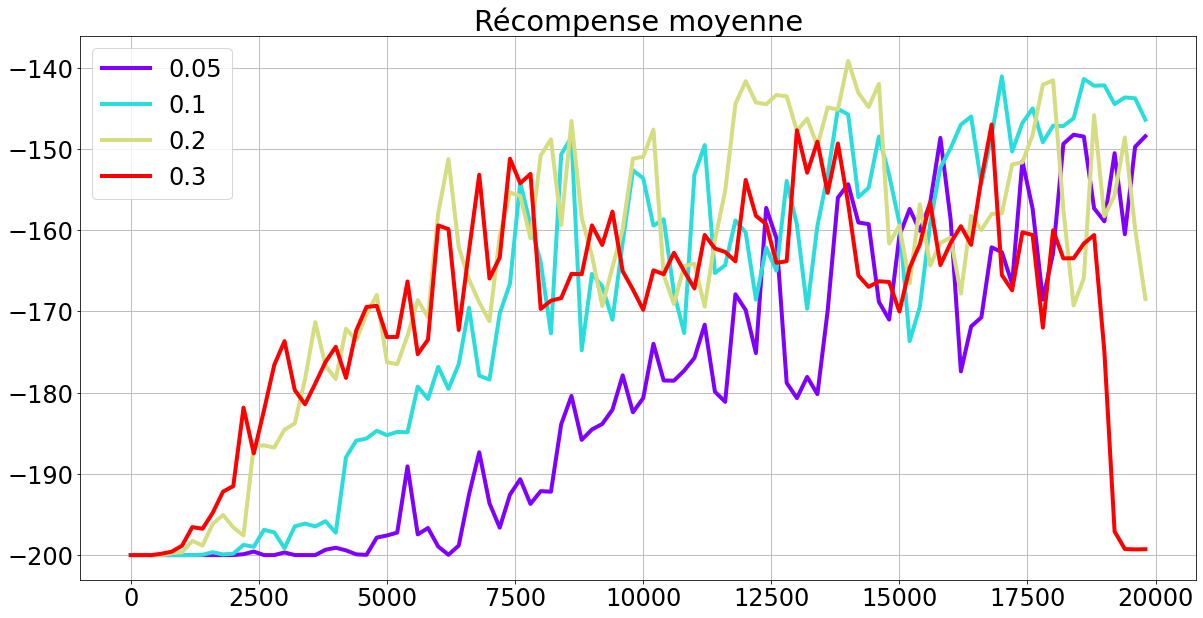

In [142]:
colors = cm.rainbow(np.linspace(0, 1, len(ALPHAS)))
for (cle, valeur), col in zip(res_alp.items(), colors):
    plt.plot(valeur['ep'], valeur['avg'], label=cle, c=col)
plt.title('Récompense moyenne')
plt.legend()
plt.show()

D'apères l'étude sur les hyperparamètres nous pouvons constater que ceux choisis au début du notebook sont ceux permettant de maximiser la récompense moyenne, et aussi de minimiser dans le temps le nombre d'itérations nécessaire pour atteindre le drapeau. 